In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

## 데이터 로드 / EDA / 전처리

### 데이터 로드

In [3]:
file = open("C:/Users/c/Desktop/ML programming/WISDM_ar_v1.1_raw.txt")

In [4]:
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [5]:
# 컬럼 추가
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [6]:
df = pd.DataFrame(data = processedList, columns = columns)
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')
df['user'] = df['user'].astype('int')
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


### 전처리

In [7]:
test_df = df[df['user'] > 27]
train_df = df[df['user'] <= 27]
test_df.shape, train_df.shape

((141681, 6), (201735, 6))

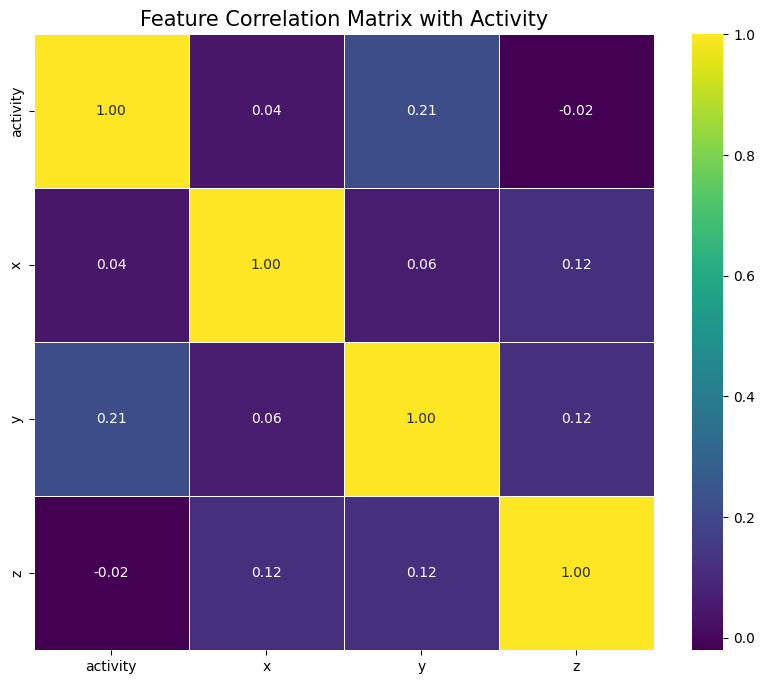

In [8]:
corr_df = train_df.copy()

# 시각화용 LabelEncoder 생성 및 적용
le_corr = LabelEncoder()
corr_df['activity'] = le_corr.fit_transform(corr_df['activity'])

# 상관관계 분석할 특성 선택 (activity 포함)
features_for_corr = ['activity', 'x', 'y', 'z']
corr_matrix = corr_df[features_for_corr].corr()

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Matrix with Activity', fontsize=15)
plt.show()


In [9]:
label_encoder = LabelEncoder()

train_df['activity'] = label_encoder.fit_transform(train_df['activity'])
test_df['activity'] = label_encoder.transform(test_df['activity'])

C:\Users\c\AppData\Local\Temp\ipykernel_3188\4128002732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['activity'] = label_encoder.fit_transform(train_df['activity'])
C:\Users\c\AppData\Local\Temp\ipykernel_3188\4128002732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['activity'] = label_encoder.transform(test_df['activity'])


In [10]:
feature_columns_to_scale = ['x', 'y', 'z']

scaler = StandardScaler()
train_df[feature_columns_to_scale] = scaler.fit_transform(train_df[feature_columns_to_scale])

test_df[feature_columns_to_scale] = scaler.transform(test_df[feature_columns_to_scale])

C:\Users\c\AppData\Local\Temp\ipykernel_3188\2326556507.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_columns_to_scale] = scaler.fit_transform(train_df[feature_columns_to_scale])
C:\Users\c\AppData\Local\Temp\ipykernel_3188\2326556507.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[feature_columns_to_scale] = scaler.transform(test_df[feature_columns_to_scale])


In [11]:
# hop_size를 frame_size 보다 작게 설정하여 중복하여 고려할 수 있게 함 (오버래핑)
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40
col = ['x', 'y', 'z', 'activity']
feature_cols = ['x', 'y', 'z']
label_col = 'activity'

In [12]:
def get_frames(df, frame_size, hop_size):
  """
  시계열 데이터를 CNN이 이해할 수 있게 재구성함.
  x,y,z 값을 각각의 채널로 나누고
  연속적인 데이터를 독립적인 여러개의 데이터로 나눔 (슬라이딩 윈도우 분할).
  이는 고정된 길이의 입력만 받을 수 있는 CNN 특성에서 기인함.

  Args:
    df: 데이터 프레임
    frame_size: 슬라이딩 윈도우 분할 사이즈
    hop_size: 슬라이딩 윈도우 사이즈

  Returns:
    frames: 분할된 데이터
    labels: 분할된 데이터의 레이블
  """
  N_FEATURES = len(feature_cols)
  
  # 사용할 피처 컬럼 목록 정의
  feature_columns = feature_cols

  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
      frame = df[feature_cols].values[i: i + frame_size]
      label = df[label_col][i: i + frame_size].mode()[0]
      
      frames.append(frame)
      labels.append(label)

  # NumPy 배열로 변환
  frames = np.asarray(frames)
  labels = np.asarray(labels).astype(int)

  return frames, labels

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
     
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## CNN + LSTM

In [ ]:
class CNN_LSTM_Classifier(nn.Module):
    def __init__(self, input_size, num_classes, lstm_hidden_size=128, lstm_layers=2, bidirectional=True, dropout=0.5):
        super(CNN_LSTM_Classifier, self).__init__()
        
        self.lstm_hidden_size = lstm_hidden_size
        self.bidirectional_factor = 2 if bidirectional else 1
    
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)  
            
            # nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm1d(128),
            # nn.ReLU() 
        )
        
        cnn_output_features = 128 
        

        self.lstm = nn.LSTM(
            input_size=cnn_output_features,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if lstm_layers > 1 else 0
        )
        
        classifier_input_size = lstm_hidden_size * self.bidirectional_factor
        
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_size, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        x = self.cnn_extractor(x) 
        
        x = x.permute(0, 2, 1)
        
        out, _ = self.lstm(x) 
        
        final_hidden_state = out[:, -1, :]
        
        logits = self.classifier(final_hidden_state) 

        return logits

In [40]:
n_splits = 5
groups = train_df['user']
gkf = GroupKFold(n_splits=n_splits)

fold_validation_indices = []
fold_model_paths = []

fold_histories = [] 

best_val_loss = float('inf')
best_model_path = './WISDM_CNNLSTM_Checkpoint' 

for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, train_df['activity'], groups)):
    print(f"===================== FOLD {fold+1}/{n_splits} =====================")
    
    fold_validation_indices.append(val_idx)
    fold_checkpoint_path = f'./WISDM_CNNLSTM_Checkpoint/checkpoint_fold_{fold+1}.pt'
    fold_model_paths.append(fold_checkpoint_path)

    fold_history_data = {
        'fold': fold + 1,
        'history': {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fold_train = train_df[col].iloc[train_idx]
    fold_val = train_df[col].iloc[val_idx] 

    X_train, y_train = get_frames(fold_train, frame_size, hop_size)
    X_val, y_val = get_frames(fold_val, frame_size, hop_size)
    

    if len(X_train) == 0 or len(X_val) == 0:
        print(f"Fold {fold+1} skipped due to insufficient data after framing.")
        fold_histories.append(fold_history_data) 
        continue

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    model = CNN_LSTM_Classifier(input_size=3, num_classes=6)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    epochs = 100 
    patience = 5
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=fold_checkpoint_path) 

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if torch.isnan(loss):
             print(f"WARNING: Train loss is NaN. Skipping batch.")
             continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        running_test_loss = 0.0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = running_test_loss / len(val_loader.dataset)
        test_accuracy = accuracy_score(all_labels, all_predictions)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Val Acc: {test_accuracy*100:.2f}%")
        
        fold_history_data['history']['train_loss'].append(train_loss)
        fold_history_data['history']['val_loss'].append(test_loss)
        fold_history_data['history']['val_acc'].append(test_accuracy)

        scheduler.step(test_loss)
        early_stopping(test_loss, model)
        
        if early_stopping.early_stop:
            print(f"Fold {fold+1} stopped early.")
            break
            
    if not early_stopping.early_stop:
        print(f"Fold {fold+1} finished all {epochs} epochs.")

    fold_histories.append(fold_history_data)

    if early_stopping.val_loss_min < best_val_loss:
        print(f"✨ New best overall model found in Fold {fold+1} with Val Loss: {early_stopping.val_loss_min:.6f}")
        best_val_loss = early_stopping.val_loss_min
        best_model_path = early_stopping.path 
    

print("\n===================== K-Fold Training Finished =====================")
print(f"All {n_splits} folds trained.")
print(f"Saved model paths: {fold_model_paths}")
print(f"Validation indices for each fold are stored in 'fold_validation_indices'.")
print(f"Best overall model (lowest val loss) saved at: {best_model_path} with val_loss: {best_val_loss:.6f}")

===================== FOLD 1/5 =====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.9091, Val Loss: 1.6782, Val Acc: 30.29%
Validation loss decreased (inf --> 1.678169).  Saving model ...
Epoch [2/100], Train Loss: 1.6923, Val Loss: 1.5250, Val Acc: 54.95%
Validation loss decreased (1.678169 --> 1.524982).  Saving model ...
Epoch [3/100], Train Loss: 1.5470, Val Loss: 1.4143, Val Acc: 67.68%
Validation loss decreased (1.524982 --> 1.414272).  Saving model ...
Epoch [4/100], Train Loss: 1.4322, Val Loss: 1.3643, Val Acc: 72.86%
Validation loss decreased (1.414272 --> 1.364283).  Saving model ...
Epoch [5/100], Train Loss: 1.3535, Val Loss: 1.2940, Val Acc: 74.66%
Validation loss decreased (1.364283 --> 1.294030).  Saving model ...
Epoch [6/100], Train Loss: 1.3100, Val Loss: 1.2376, Val Acc: 78.83%
Validation loss decreased (1.294030 --> 1.237592).  Saving model ...
Epoch [7/100], Train Loss: 1.2453, Val Loss: 1.1958, Val Acc: 81.08%
Validation loss decreased (1.237592 --> 1.195771).  Saving model ...
Epoch [8/100], Train Loss: 1.1994, Val 

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7694, Val Loss: 1.6887, Val Acc: 40.48%
Validation loss decreased (inf --> 1.688684).  Saving model ...
Epoch [2/100], Train Loss: 1.5114, Val Loss: 1.5057, Val Acc: 62.04%
Validation loss decreased (1.688684 --> 1.505720).  Saving model ...
Epoch [3/100], Train Loss: 1.3400, Val Loss: 1.4016, Val Acc: 62.61%
Validation loss decreased (1.505720 --> 1.401639).  Saving model ...
Epoch [4/100], Train Loss: 1.2265, Val Loss: 1.3079, Val Acc: 62.61%
Validation loss decreased (1.401639 --> 1.307890).  Saving model ...
Epoch [5/100], Train Loss: 1.1443, Val Loss: 1.2739, Val Acc: 63.65%
Validation loss decreased (1.307890 --> 1.273879).  Saving model ...
Epoch [6/100], Train Loss: 1.0797, Val Loss: 1.2150, Val Acc: 61.93%
Validation loss decreased (1.273879 --> 1.214990).  Saving model ...
Epoch [7/100], Train Loss: 1.0240, Val Loss: 1.1867, Val Acc: 62.50%
Validation loss decreased (1.214990 --> 1.186673).  Saving model ...
Epoch [8/100], Train Loss: 0.9622, Val 

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.9628, Val Loss: 1.6547, Val Acc: 32.27%
Validation loss decreased (inf --> 1.654717).  Saving model ...
Epoch [2/100], Train Loss: 1.6929, Val Loss: 1.4364, Val Acc: 43.16%
Validation loss decreased (1.654717 --> 1.436389).  Saving model ...
Epoch [3/100], Train Loss: 1.5143, Val Loss: 1.3160, Val Acc: 45.05%
Validation loss decreased (1.436389 --> 1.316024).  Saving model ...
Epoch [4/100], Train Loss: 1.3488, Val Loss: 1.2217, Val Acc: 46.55%
Validation loss decreased (1.316024 --> 1.221739).  Saving model ...
Epoch [5/100], Train Loss: 1.2519, Val Loss: 1.1410, Val Acc: 52.25%
Validation loss decreased (1.221739 --> 1.140987).  Saving model ...
Epoch [6/100], Train Loss: 1.1692, Val Loss: 1.1112, Val Acc: 53.95%
Validation loss decreased (1.140987 --> 1.111228).  Saving model ...
Epoch [7/100], Train Loss: 1.1040, Val Loss: 1.0738, Val Acc: 58.54%
Validation loss decreased (1.111228 --> 1.073751).  Saving model ...
Epoch [8/100], Train Loss: 1.0407, Val 

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.9522, Val Loss: 1.8476, Val Acc: 31.31%
Validation loss decreased (inf --> 1.847628).  Saving model ...
Epoch [2/100], Train Loss: 1.7331, Val Loss: 1.6769, Val Acc: 31.98%
Validation loss decreased (1.847628 --> 1.676909).  Saving model ...
Epoch [3/100], Train Loss: 1.5229, Val Loss: 1.5351, Val Acc: 45.83%
Validation loss decreased (1.676909 --> 1.535085).  Saving model ...
Epoch [4/100], Train Loss: 1.3945, Val Loss: 1.4101, Val Acc: 65.54%
Validation loss decreased (1.535085 --> 1.410091).  Saving model ...
Epoch [5/100], Train Loss: 1.2659, Val Loss: 1.3036, Val Acc: 74.10%
Validation loss decreased (1.410091 --> 1.303639).  Saving model ...
Epoch [6/100], Train Loss: 1.1718, Val Loss: 1.2367, Val Acc: 74.89%
Validation loss decreased (1.303639 --> 1.236668).  Saving model ...
Epoch [7/100], Train Loss: 1.0963, Val Loss: 1.1607, Val Acc: 78.94%
Validation loss decreased (1.236668 --> 1.160664).  Saving model ...
Epoch [8/100], Train Loss: 1.0313, Val 

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.8294, Val Loss: 1.7447, Val Acc: 20.65%
Validation loss decreased (inf --> 1.744694).  Saving model ...
Epoch [2/100], Train Loss: 1.6233, Val Loss: 1.4771, Val Acc: 66.64%
Validation loss decreased (1.744694 --> 1.477148).  Saving model ...
Epoch [3/100], Train Loss: 1.4523, Val Loss: 1.2971, Val Acc: 83.54%
Validation loss decreased (1.477148 --> 1.297101).  Saving model ...
Epoch [4/100], Train Loss: 1.3225, Val Loss: 1.1827, Val Acc: 86.86%
Validation loss decreased (1.297101 --> 1.182729).  Saving model ...
Epoch [5/100], Train Loss: 1.2205, Val Loss: 1.1030, Val Acc: 87.44%
Validation loss decreased (1.182729 --> 1.103032).  Saving model ...
Epoch [6/100], Train Loss: 1.1405, Val Loss: 1.0080, Val Acc: 88.45%
Validation loss decreased (1.103032 --> 1.007974).  Saving model ...
Epoch [7/100], Train Loss: 1.0764, Val Loss: 0.9555, Val Acc: 88.09%
Validation loss decreased (1.007974 --> 0.955467).  Saving model ...
Epoch [8/100], Train Loss: 1.0256, Val 

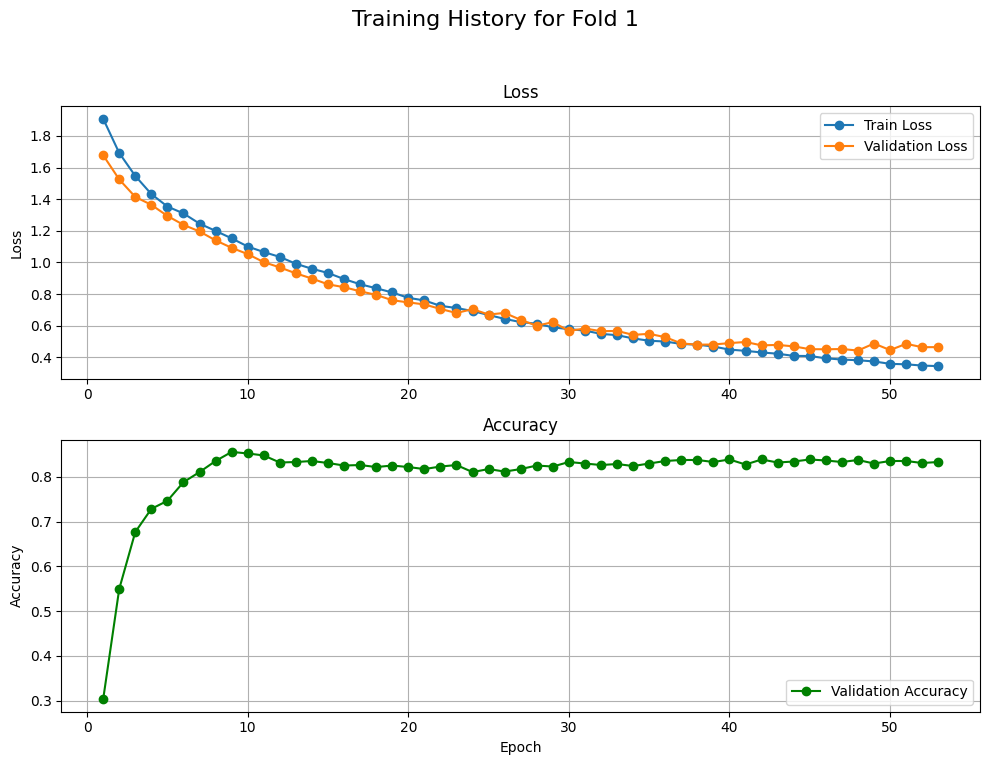

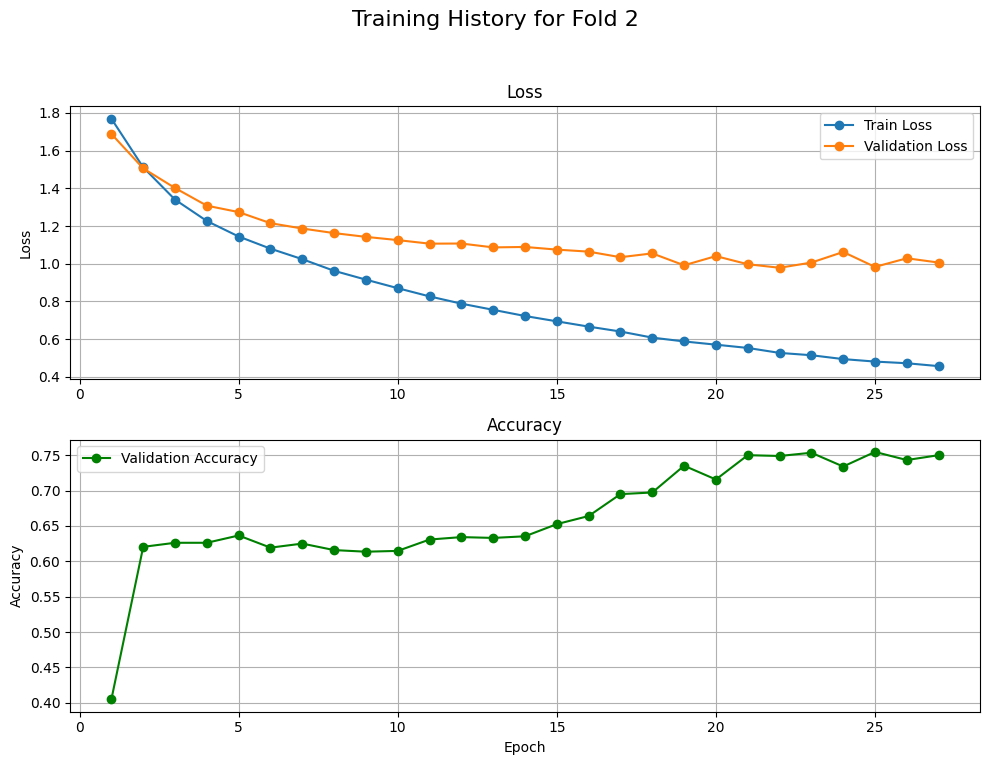

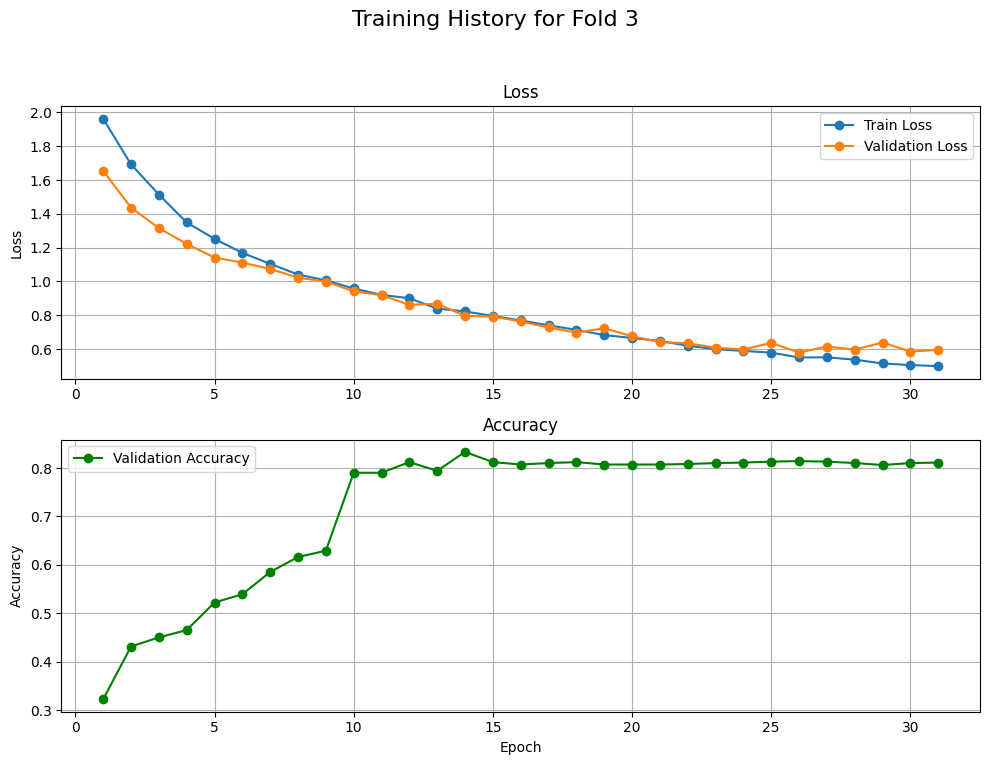

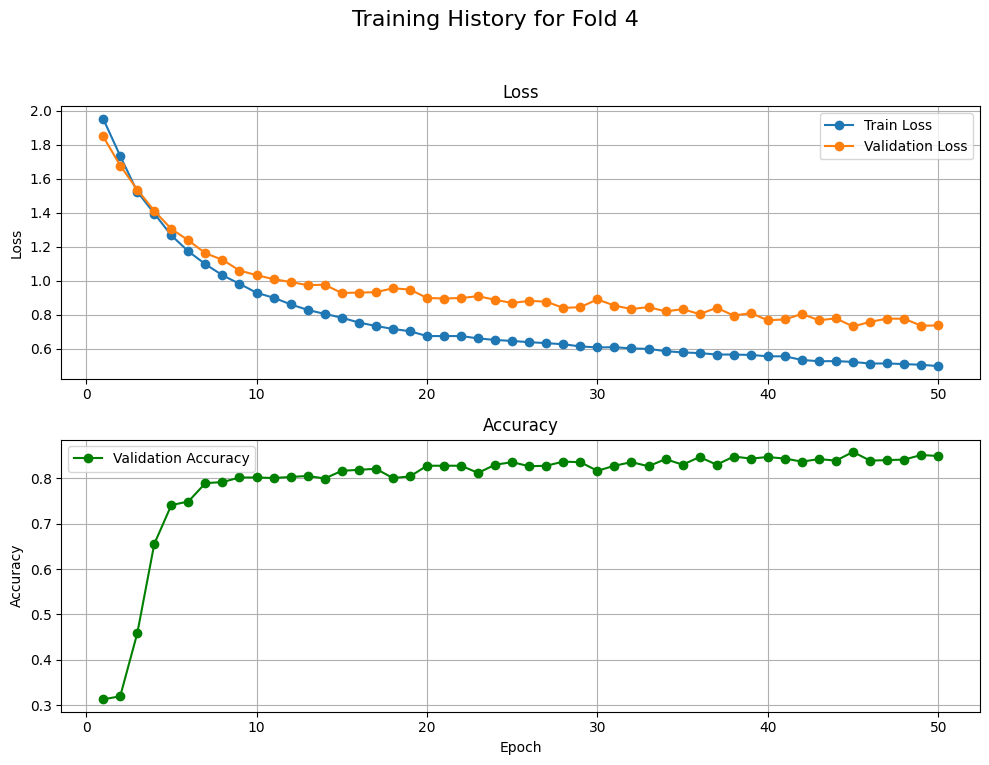

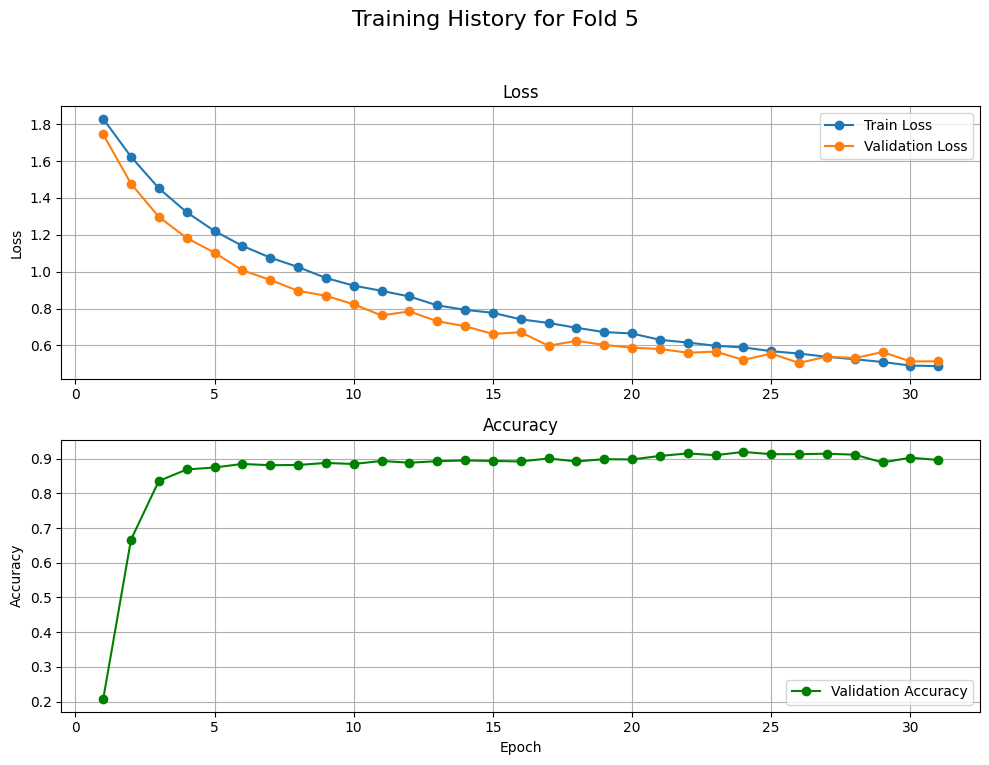

In [41]:
for hist_data in fold_histories:
    fold = hist_data['fold']
    history = hist_data['history']
    
    epochs = len(history['train_loss'])
    epoch_range = range(1, epochs + 1)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8)) 
    fig.suptitle(f'Training History for Fold {fold}', fontsize=16)

    # Plot Training and Validation Loss
    axes[0].plot(epoch_range, history['train_loss'], 'o-', label='Train Loss') 
    axes[0].plot(epoch_range, history['val_loss'], 'o-', label='Validation Loss') 
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Accuracy
    axes[1].plot(epoch_range, history['val_acc'], 'o-', label='Validation Accuracy', color='green') 
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

In [42]:
print("===================== Starting Final Test Set Evaluation =====================")

print(f"Preparing entire test_df (user > 27)...")
X_test, y_test = get_frames(test_df[col], frame_size, hop_size)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # batch_size는 Cell 1과 동일하게

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_accuracies = []
test_f1s = [] 
all_models_predictions = []
all_models_true_labels = []

for fold in range(n_splits): 
    print(f"--- Evaluating Model from Fold {fold+1}/{n_splits} on TEST SET ---")
    
    
    model_path = fold_model_paths[fold] 
    
   
    print(f"Loading model from {model_path}...")
    best_model = CNN_LSTM_Classifier(input_size=3, num_classes=6)
    best_model.load_state_dict(torch.load(model_path))
    best_model.to(device)
    best_model.eval()

    # 전체 Test Set으로 예측 수행
    fold_test_predictions = []
    fold_test_true_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            fold_test_predictions.extend(predicted.cpu().numpy())
            fold_test_true_labels.extend(labels.cpu().numpy())

    fold_test_acc = accuracy_score(fold_test_true_labels, fold_test_predictions)
    fold_test_f1_macro = f1_score(fold_test_true_labels, fold_test_predictions, average='macro', zero_division=0)
    
    test_accuracies.append(fold_test_acc)
    test_f1s.append(fold_test_f1_macro)  
    
    print(f"Model {fold+1} Test Accuracy: {fold_test_acc*100:.2f}%, Test F1 (Macro): {fold_test_f1_macro:.4f}")
    
    all_models_predictions.append(fold_test_predictions)
    
    if not all_models_true_labels: 
        all_models_true_labels = fold_test_true_labels

===================== Starting Final Test Set Evaluation =====================
Preparing entire test_df (user > 27)...
--- Evaluating Model from Fold 1/5 on TEST SET ---
Loading model from ./WISDM_CNNLSTM_Checkpoint/checkpoint_fold_1.pt...


C:\Users\c\AppData\Local\Temp\ipykernel_3188\4117613932.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))


Model 1 Test Accuracy: 72.95%, Test F1 (Macro): 0.4403
--- Evaluating Model from Fold 2/5 on TEST SET ---
Loading model from ./WISDM_CNNLSTM_Checkpoint/checkpoint_fold_2.pt...
Model 2 Test Accuracy: 67.18%, Test F1 (Macro): 0.3537
--- Evaluating Model from Fold 3/5 on TEST SET ---
Loading model from ./WISDM_CNNLSTM_Checkpoint/checkpoint_fold_3.pt...


C:\Users\c\AppData\Local\Temp\ipykernel_3188\4117613932.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))
C:\Users\c\Ap

Model 3 Test Accuracy: 63.29%, Test F1 (Macro): 0.3488
--- Evaluating Model from Fold 4/5 on TEST SET ---
Loading model from ./WISDM_CNNLSTM_Checkpoint/checkpoint_fold_4.pt...
Model 4 Test Accuracy: 61.93%, Test F1 (Macro): 0.3621
--- Evaluating Model from Fold 5/5 on TEST SET ---
Loading model from ./WISDM_CNNLSTM_Checkpoint/checkpoint_fold_5.pt...
Model 5 Test Accuracy: 67.01%, Test F1 (Macro): 0.3904


C:\Users\c\AppData\Local\Temp\ipykernel_3188\4117613932.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))
C:\Users\c\Ap


===================== Classification Report (Best Model - Fold 1) =====================
              precision    recall  f1-score   support

  Downstairs       0.34      0.59      0.43       384
     Jogging       0.99      0.74      0.85      1313
     Sitting       0.00      0.00      0.00        63
    Standing       0.00      0.00      0.00        48
    Upstairs       0.40      0.63      0.49       405
     Walking       0.91      0.85      0.88      1328

    accuracy                           0.73      3541
   macro avg       0.44      0.47      0.44      3541
weighted avg       0.79      0.73      0.75      3541


===================== Confusion Matrix (Best Model - Fold 1) =====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

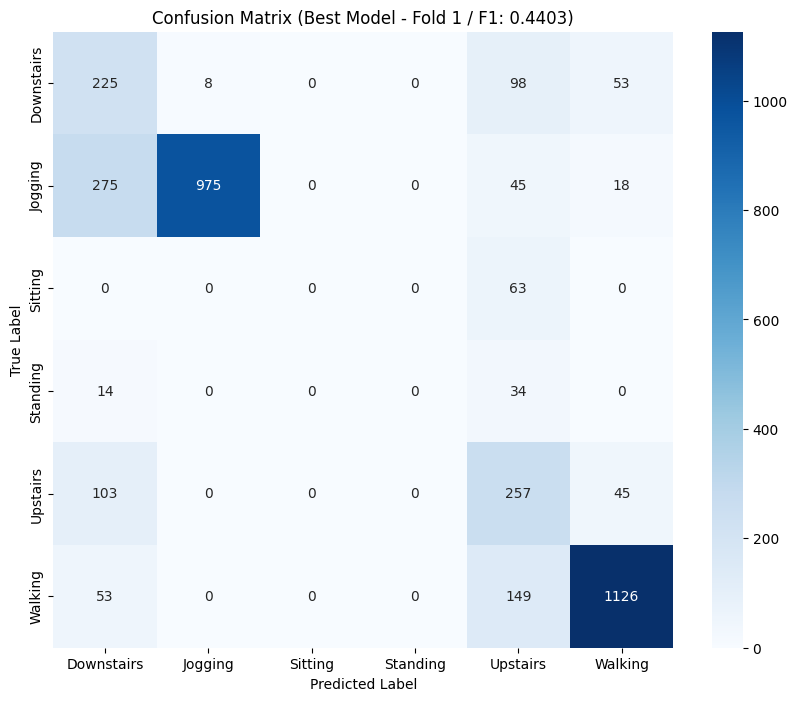

In [43]:
best_fold_index = np.argmax(test_f1s)
best_fold_predictions = all_models_predictions[best_fold_index]

print(f"\n===================== Classification Report (Best Model - Fold {best_fold_index+1}) =====================")

try:
    target_names = label_encoder.classes_
except NameError:
    target_names = [str(i) for i in range(6)]

print(classification_report(all_models_true_labels, best_fold_predictions, target_names=target_names))

print(f"\n===================== Confusion Matrix (Best Model - Fold {best_fold_index+1}) =====================")
cm = confusion_matrix(all_models_true_labels, best_fold_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (Best Model - Fold {best_fold_index+1} / F1: {test_f1s[best_fold_index]:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()